# Отток клиентов

 <b> Описание проекта </b>
 
 Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
 
 <b>Цель проекта</b>
 
 Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
 
 <b> Задачи проекта</b>
 
 Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)
 
 
 <b>Данной проект разделим на несколько частей:</b>
 
 <b> Изучение общей информации:</b>
 
  [Импортируем необходимые библиотеки](#step_1)
  
  [Подготовка данных](#step_2)
  
  [Исследование задачи](#step_3)
   
  [Борьба с дисбалансом](#step_4)
  
  [Тестирование модели](#step_5)
  
  [<b> Общий вывод </b>](#step_6)
  
  [Чек-лист готовности проекта](#step_7)

<a id="step_1"></a>
<b>Импортируем необходимые библиотеки</b>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier


#При записи изменённых признаков в исходный датафрейм код может вызывать предупреждение SettingWithCopy.
#Причина в особенности поведения sklearn и pandas. Специалисты уже привыкли игнорировать такое сообщение.
#Чтобы предупреждение не появлялось, в код добавляют строчку
pd.options.mode.chained_assignment = None

<a id="step_2"></a>
<b>Подготовка данных</b>

In [2]:
#загрузим наши данные
try:
    df = pd.read_csv ('/datasets/Churn.csv')
except:
    df = pd.read_csv ('Churn.csv')

In [3]:
#создадим функцию для первичного предпросмотра того, что имеем
def first_look (df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (df.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2), '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
        print ('------------- Дубликаты ------------')
        if df.duplicated().sum() > 0:
            print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
# ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме 
    min_unique = limit_na_category + 1
    for element in df.columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('------------- Категориальные признаки ------------')
    for element in df.columns:
        if df[element].nunique() <= limit_na_category: 
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

In [4]:
#посмотрим на наши данные
first_look (df)

------------- Первые 5 строк ------------


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


------------- Пропуски ------------
Tenure  -  909 пропусков,  9.09 % от числа строк.
Дубликатов НЕТ











------------- Категориальные признаки ------------
Geography :  3 категории -  ['France' 'Spain' 'Germ

Из условий задачи мы знаем значение столбцов, а именно, <b>признаки</b>:

•	RowNumber — индекс строки в данных

•	CustomerId — уникальный идентификатор клиента

•	Surname — фамилия

•	CreditScore — кредитный рейтинг

•	Geography — страна проживания

•	Gender — пол

•	Age — возраст

•	Tenure — сколько лет человек является клиентом банка

•	Balance — баланс на счёте

•	NumOfProducts — количество продуктов банка, используемых клиентом

•	HasCrCard — наличие кредитной карты

•	IsActiveMember — активность клиента

•	EstimatedSalary — предполагаемая зарплата

<b>Целевой признак:</b>

•	Exited — факт ухода клиента

Т.к. значения столбцов RowNumber, CustomerId и Surname смысловой нагрузки для решения нашей задачи не несут, ими можно пренебречь, а именно - удалить

In [5]:
df = df.drop (['Surname', 'RowNumber', 'CustomerId'], axis=1)

In [6]:
#посчитаем процент ушедших клиентов с неуказанным сроком прибывания в банке в виде клиента (Tenure - не заполненно)
display (df [df ['Tenure'].isna () == True]['Exited'].sum () / df [df ['Tenure'].isna () == True]['Exited'].count ())

#посчитаем процент ушедших клиентов с указанным сроком прибывания в банке в виде клиента (Tenure - заполненно)
display (df [df ['Tenure'].isna () == False]['Exited'].sum () / df [df ['Tenure'].isna () == False]['Exited'].count ())

0.20132013201320131

0.2039379606203938

По имеющимся данным мы не можем сделать однозначного предположения о появлении пропусков в данных о том, сколько лет человек является клиентом банка. Данный вопрос необходимо уточнить, т.к. он может являться еще одним критерием для проверки предположений о потере либо нет клиента.

На данный момент предположим, что пропуски в данных являются признаком новых клиентов, тем самым заполним их нулями, если же наше предположение в дальнейшем окажется ошибочным, пересчитаем полученные результаты в связи с вновь открывшимися обстоятельствами.

In [7]:
df ['Tenure'] = df ['Tenure'].fillna (0).astype ('int')

Чтобы избежать попадание в дамми-ловушку нам необходимо перекодировать классы в столбцах Geography и Gender методом One-Hot Encoding

In [8]:
df_ohe = pd.get_dummies (df, drop_first = True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Подготовим данные для дальнейших исследований, а именно:

1. Сформируем из нашей выборки выборку с параментрами признаков и целевыми параметрами
2. Разделим наши выборки на тренировочную, валидационную и тестовую в соотношениях 60:20:20

In [9]:
#Сформируем параметры признаков и целевой признак
features = df_ohe.drop (['Exited'], axis = 1)
target = df_ohe ['Exited']

In [10]:
#Разделим наши выборки на тренировочную, валидационную и тестовую в соотношениях 60:20:20
features_train, features_valid, target_train, target_valid = train_test_split (features, target, test_size = 0.4, 
                                                                              random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split (features_valid, target_valid, test_size = 0.5, 
                                                                              random_state = 12345 )
print (features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


Т.к. у нас в столбцах 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary' имеется разный масштаб представленных значений, нам необходимо их маштабировать. Применим один из методов масшабирования - стандартизация.

In [11]:
#Масштабируем численные признаки выборок для выравнивания весов
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

#Создадим объект этой структуры и настроим его на обучающих данных. Настройка — это вычисление среднего и дисперсии:
scaler = StandardScaler()
scaler.fit (features_train) 

#Преобразуем обучающую, валидационную и тестовые выборки функцией transform().
scaler = StandardScaler ()
scaler.fit (features_train [numeric])

features_train [numeric] = scaler.transform (features_train [numeric])
features_valid [numeric] = scaler.transform (features_valid [numeric])
features_test [numeric] = scaler.transform (features_test [numeric])

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268,1,0,0


На данном этапе мы предобработали данные, а именно:

1. Рассмотрели из чего состоят наши данные

2. Нашли данные с пропусками и заменили пропучки

3. Убедились в отсутствии дубликатов

4. Выявили столбцы с категориальными признаками

5. Избавились от столбцов с данными, которые для нас не представляют особого интереса и не повлияют на следующие модели

6. Чтобы избежать попадание в дамми-ловушку перекодировали классы в столбцах Geography и Gender методом One-Hot Encoding

7. Сформировали из нашей выборки выборку с параментрами признаков и целевыми параметрами

8. Разделили наши выборки на тренировочную, валидационную и тестовую в соотношениях 60:20:20

9. Маштабировали (стандартизировали) данные в столбцах 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary' во всем наших выборках

<a id="step_3"></a>
<b>Исследование задачи</b>

Перед началом исследований нам необходимо проверить целевой параментр на дисбаланс классов, постоим график  количества ушедших к оставшимся клиентам

In [12]:
#создадим табличку с нашими результатами
data = {'model' : ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'],
                'disbalance' : [0, 0, 0],
               'upsample' : [0, 0, 0],
                'downsampled' : [0, 0, 0]}
data_results = pd.DataFrame (data)

0    0.7963
1    0.2037
Name: Exited, dtype: float64


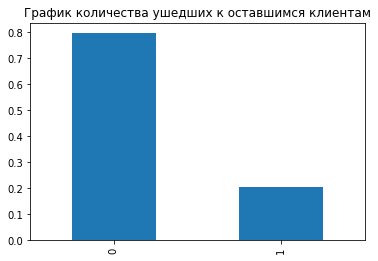

In [13]:
class_frequency = df ['Exited'].value_counts (normalize = bool)
print (class_frequency)
class_frequency.plot (kind = 'bar', title = 'График количества ушедших к оставшимся клиентам')

На лицо имеется явный дисбаланс классов, что плохо сказывается на обучении моделей, мы понимаем, что при обучении модель будет склоняться к распространненому варианту ответа - клиент остался, т.к. дисбаланс почти в 4 раза.

<b>Обучим и оценим метрики с помощью модели логистической регрессии </b>

In [14]:
model_LogisticRegression_DisbalanceClass =  LogisticRegression (random_state=12345, solver='liblinear')
model_LogisticRegression_DisbalanceClass.fit (features_train, target_train)
prediction = model_LogisticRegression_DisbalanceClass.predict (features_valid)

print ('Accuracy', accuracy_score (target_valid, prediction))
print ('Precision', precision_score (target_valid, prediction))
print ('Recall', recall_score (target_valid, prediction))
print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_LogisticRegression_DisbalanceClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score (target_valid, probabilities_valid))
data_results.loc [0, 'disbalance'] = f1_score (target_valid, prediction)

Accuracy 0.8025
Precision 0.5657142857142857
Recall 0.23684210526315788
F1 0.33389544688026984
AUC-ROC 0.7586317967081824


В данной модели значение полноты далеко отстаит от точности, что влияет на оценку агрегирующей метрики (F1) да и значение AUC-ROC далеко от идеала 

<b>Обучим и оценим метрики с помощью модели дерева решений</b>

In [15]:
#вычислим наиболее лучшую глубину
best_f1 = 0
best_depth = 0
for depth in range(1, 20):
    model_DecisionTreeClassifier_DisbalanceClass = DecisionTreeClassifier (random_state = 12345, max_depth = depth)
    model_DecisionTreeClassifier_DisbalanceClass.fit (features_train, target_train)
    prediction = model_DecisionTreeClassifier_DisbalanceClass.predict (features_valid)
    f1 = f1_score (target_valid, prediction)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth

#на основе вычислений лучшей глубины обучим модель
model_DecisionTreeClassifier_DisbalanceClass = DecisionTreeClassifier (max_depth = best_depth, random_state = 12345)
model_DecisionTreeClassifier_DisbalanceClass.fit (features_train, target_train)
prediction = model_DecisionTreeClassifier_DisbalanceClass.predict (features_valid)

#выведем результаты на экран
print ('Best depth', best_depth)
print ('Accuracy', accuracy_score (target_valid, prediction))
print ('Precision', precision_score (target_valid, prediction))
print ('Recall', recall_score (target_valid, prediction))
print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_DecisionTreeClassifier_DisbalanceClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score(target_valid, probabilities_valid))
data_results.loc [1, 'disbalance'] = f1_score (target_valid, prediction)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best depth 9
Accuracy 0.85
Precision 0.7006802721088435
Recall 0.49282296650717705
F1 0.5786516853932585
AUC-ROC 0.7899719632952051


В данной модели значение полноты далеко отстаит от точности, что влияет на оценку агрегирующей метрики (F1) да и значение AUC-ROC далеко от идеала, но уже дучше, чем с модель. логистической регрессии

<b>Обучим и оценим метрики с помощью модели случайного леса</b>

In [16]:
best_f1 = 0
best_estim = 0
best_depth = 0

for estim in range (60, 65):
    for depth in range (10, 14):
        model_RandomForestClassifier_DisbalanceClass = RandomForestClassifier (n_estimators = estim, max_depth = depth, random_state = 12345)
        model_RandomForestClassifier_DisbalanceClass.fit (features_train, target_train)
        prediction = model_RandomForestClassifier_DisbalanceClass.predict (features_valid)
        f1 = f1_score (target_valid, prediction)
        if f1 > best_f1:
            best_f1 = f1
            best_estim = estim
            best_depth = depth
        

print('Лучшее количество деревьев:', best_estim, 'При лучшей глубине:', best_depth, 'с лучшим результатов агрегирующей метрики (F1-score)', best_f1)

model_RandomForestClassifier_DisbalanceClass = RandomForestClassifier (n_estimators = best_estim, max_depth = best_depth, random_state = 12345)
model_RandomForestClassifier_DisbalanceClass.fit (features_train, target_train)
prediction = model_RandomForestClassifier_DisbalanceClass.predict (features_valid)
print ('Accuracy', accuracy_score (target_valid, prediction))
print ('Precision', precision_score (target_valid, prediction))
print ('Recall', recall_score (target_valid, prediction))
print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_RandomForestClassifier_DisbalanceClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score (target_valid, probabilities_valid))
data_results.loc [2, 'disbalance'] = f1_score (target_valid, prediction)
display (data_results)

Лучшее количество деревьев: 64 При лучшей глубине: 12 с лучшим результатов агрегирующей метрики (F1-score) 0.5905631659056315
Accuracy 0.8655
Precision 0.8117154811715481
Recall 0.46411483253588515
F1 0.5905631659056315
AUC-ROC 0.8464188931701739


,model,disbalance,upsample,downsampled
0,LogisticRegression,0.333895,0,0
1,DecisionTreeClassifier,0.578652,0,0
2,RandomForestClassifier,0.590563,0,0


В данной модели значение полноты уже намного лучше сочетается с  точностью, что влияет на оценку агрегирующей метрики (F1) да и значение AUC-ROC приближается к 0,9.

При анализе наших обучений моделей разными методами можно сделать вывод о том, что из-за несбалансированности классов полнота отстоит от точности достаточно, что влияет на оценку агрегирующей метрики (F1), только модель со случайным лесом начинает приближаться к приемлимуму значению F1-меры и AUC-ROC.

<a id="step_4"></a>
<b>Борьба с дисбалансом</b>

Попробуем увеличить нашу выборку для положительных решений, т.к. их доля мала по сравнению с отрицательными решениями и они перевешивают наши модели на свою сторону

In [17]:
#напишем функцию увеличения выборки
def upsample (features, target, repeat):
    #разделим выборку по значениям целевых показателей
    target_one = target [target == 1]
    target_zero = target [target == 0]
    features_one = features [target ==1]
    features_zero  = features [target == 0]
    
    #увеличим и соединим обратно
    features_upsample = pd.concat ([features_zero] + [features_one] * repeat)
    target_upsample = pd.concat ([target_zero] + [target_one] * repeat)
    
    #перемешаем для более точного результата
    features_upsample, target_upsample = shuffle (features_upsample, target_upsample, random_state = 12345)
    
    return features_upsample, target_upsample

In [18]:
features_upsample, target_upsample = upsample (features_train, target_train, 4)

features_zero = features_upsample [target_upsample == 0]
features_one = features_upsample [target_upsample == 1]

print(features_zero.shape[0])
print(features_one.shape[0])

4804
4784


<b>Обучим и оценим увеличенные метрики с помощью модели логистической регрессии</b>

In [19]:
model_LogisticRegression_UpsampleClass =  LogisticRegression (random_state = 12345, solver = 'liblinear')
model_LogisticRegression_UpsampleClass.fit (features_upsample, target_upsample)
prediction = model_LogisticRegression_UpsampleClass.predict (features_valid)

print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_LogisticRegression_UpsampleClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score (target_valid, probabilities_valid))
data_results.loc [0, 'upsample'] = f1_score (target_valid, prediction)
fpr_LogisticRegression_UpsampleClass, tpr_LogisticRegression_UpsampleClass, thresholds = roc_curve (target_valid, probabilities_valid)

F1 0.4888888888888888
AUC-ROC 0.7634769748183815


<b>Обучим и оценим увеличенные метрики с помощью модели дерева решений</b>

In [20]:
#вычислим наиболее лучшую глубину
best_f1 = 0
best_depth = 0
for depth in range(1, 20):
    model_DecisionTreeClassifier_UpsampleClass = DecisionTreeClassifier (random_state = 12345, max_depth = depth)
    model_DecisionTreeClassifier_UpsampleClass.fit (features_upsample, target_upsample)
    prediction = model_DecisionTreeClassifier_UpsampleClass.predict (features_valid)
    f1 = f1_score (target_valid, prediction)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print ('Best depth', best_depth)
#на основе вычислений лучшей глубины обучим модель
model_DecisionTreeClassifier_UpsampleClass = DecisionTreeClassifier (max_depth = best_depth, random_state = 12345)
model_DecisionTreeClassifier_UpsampleClass.fit (features_upsample, target_upsample)
prediction = model_DecisionTreeClassifier_UpsampleClass.predict (features_valid)

#выведем результаты на экран
print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_DecisionTreeClassifier_UpsampleClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score(target_valid, probabilities_valid))
data_results.loc [1, 'upsample'] = f1_score (target_valid, prediction)
fpr_DecisionTreeClassifier_UpsampleClass, tpr_DecisionTreeClassifier_UpsampleClass, thresholds = roc_curve (target_valid, probabilities_valid)

Best depth 5
F1 0.5963791267305644
AUC-ROC 0.8310244134068074


<b>Обучим и оценим увеличенные метрики с помощью модели случайного леса</b>

In [21]:
best_f1 = 0
best_estim = 0
best_depth = 0

#for estim in range (10, 160, 10):
#    for depth in range (1, 20):
for estim in range (60, 65):
    for depth in range (11, 15):
        model_RandomForestClassifier_UpsampleClass = RandomForestClassifier (n_estimators = estim, max_depth = depth, random_state = 12345)
        model_RandomForestClassifier_UpsampleClass.fit (features_upsample, target_upsample)
        prediction = model_RandomForestClassifier_UpsampleClass.predict (features_valid)
        f1 = f1_score (target_valid, prediction)
        if f1 > best_f1:
            best_f1 = f1
            best_estim = estim
            best_depth = depth
        

print('Лучшее количество деревьев:', best_estim, 'При лучшей глубине:', best_depth, 'с лучшим результатов агрегирующей метрики (F1-score)', best_f1)

model_RandomForestClassifier_UpsampleClass = RandomForestClassifier (n_estimators = best_estim, max_depth = best_depth, random_state = 12345)
model_RandomForestClassifier_UpsampleClass.fit (features_upsample, target_upsample)
prediction = model_RandomForestClassifier_UpsampleClass.predict (features_valid)

print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_RandomForestClassifier_UpsampleClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score (target_valid, probabilities_valid))
data_results.loc [2, 'upsample'] = f1_score (target_valid, prediction)
fpr_RandomForestClassifier_UpsampleClass, tpr_RandomForestClassifier_UpsampleClass, thresholds = roc_curve (target_valid, probabilities_valid)
display (data_results)

Лучшее количество деревьев: 62 При лучшей глубине: 13 с лучшим результатов агрегирующей метрики (F1-score) 0.6310679611650486
F1 0.6310679611650486
AUC-ROC 0.8449459832203193


,model,disbalance,upsample,downsampled
0,LogisticRegression,0.333895,0.488889,0
1,DecisionTreeClassifier,0.578652,0.596379,0
2,RandomForestClassifier,0.590563,0.631068,0


Попробуем уменьшить нашу выборку для отрицательных решений, т.к. их доля велика по сравнению с отрицательными решениями и они перевешивают наши модели на свою сторону

In [22]:
#напишем функцию уменьшения выборки
def downsample (features, target, fraction):
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]
    #уменьшим и соединим обратно
    features_downsampled = pd.concat(
            [features_zero.sample (frac = fraction, random_state = 12345)] + [features_one])
    
    target_downsampled = pd.concat(
            [target_zero.sample (frac = fraction, random_state = 12345)] + [target_one])

    #пеермешаем наши объекты
    features_downsampled, target_downsampled = shuffle (features_downsampled, target_downsampled, random_state = 12345)
    return features_downsampled, target_downsampled

In [23]:
features_downsampled, target_downsampled = downsample (features_train, target_train, 0.25)

features_zero = features_downsampled [target_downsampled == 0]
features_one = features_downsampled [target_downsampled == 1]

print(features_zero.shape[0])
print(features_one.shape[0])

1201
1196


<b>Обучим и оценим уменьшеной метрики с помощью модели логистической регрессии</b>

In [24]:
model_LogisticRegression_DownsampledClass =  LogisticRegression (random_state=12345, solver='liblinear')
model_LogisticRegression_DownsampledClass.fit (features_downsampled, target_downsampled)
prediction = model_LogisticRegression_DownsampledClass.predict (features_valid)

print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_LogisticRegression_DownsampledClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score (target_valid, probabilities_valid))
data_results.loc [0, 'downsampled'] = f1_score (target_valid, prediction)

F1 0.4892703862660944
AUC-ROC 0.762673981816972


<b>Обучим и оценим уменьшеной метрики с помощью модели дерева решений</b>

In [25]:
#вычислим наиболее лучшую глубину
best_f1 = 0
best_depth = 0
for depth in range(1, 20):
    model_DecisionTreeClassifier_DownsampledClass = DecisionTreeClassifier (random_state = 12345, max_depth = depth)
    model_DecisionTreeClassifier_DownsampledClass.fit (features_downsampled, target_downsampled)
    prediction = model_DecisionTreeClassifier_DownsampledClass.predict (features_valid)
    f1 = f1_score (target_valid, prediction)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print ('Best depth', best_depth)

#на основе вычислений лучшей глубины обучим модель
model_DecisionTreeClassifier_DownsampledClass = DecisionTreeClassifier (max_depth = best_depth, random_state = 12345)
model_DecisionTreeClassifier_DownsampledClass.fit (features_downsampled, target_downsampled)
prediction = model_DecisionTreeClassifier_DownsampledClass.predict (features_valid)

#выведем результаты на экран
print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_DecisionTreeClassifier_DownsampledClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score(target_valid, probabilities_valid))
data_results.loc [1, 'downsampled'] = f1_score (target_valid, prediction)

Best depth 5
F1 0.5931174089068827
AUC-ROC 0.82291433531536


<b>Обучим и оценим уменьшеной метрики с помощью модели случайного леса</b>

In [26]:
best_f1 = 0
best_estim = 0
best_depth = 0

for estim in range (60, 65):
    for depth in range (7, 11):
        model_RandomForestClassifier_DownsampledClass = RandomForestClassifier (n_estimators = estim, max_depth = depth, random_state = 12345)
        model_RandomForestClassifier_DownsampledClass.fit (features_downsampled, target_downsampled)
        prediction = model_RandomForestClassifier_DownsampledClass.predict (features_valid)
        f1 = f1_score (target_valid, prediction)
        if f1 > best_f1:
            best_f1 = f1
            best_estim = estim
            best_depth = depth
        

print('Лучшее количество деревьев:', best_estim, 'При лучшей глубине:', best_depth, 'с лучшим результатов агрегирующей метрики (F1-score)', best_f1)

model_RandomForestClassifier_DownsampledClass = RandomForestClassifier (n_estimators = best_estim, max_depth = best_depth, random_state = 12345)
model_RandomForestClassifier_DownsampledClass.fit (features_downsampled, target_downsampled)
prediction = model_RandomForestClassifier_DownsampledClass.predict (features_valid)

print ('F1', f1_score (target_valid, prediction))
probabilities_valid = model_RandomForestClassifier_DownsampledClass.predict_proba (features_valid)[:, 1]
print ("AUC-ROC", roc_auc_score (target_valid, probabilities_valid))
data_results.loc [2, 'downsampled'] = f1_score (target_valid, prediction)
display (data_results)

Лучшее количество деревьев: 62 При лучшей глубине: 9 с лучшим результатов агрегирующей метрики (F1-score) 0.5943396226415094
F1 0.5943396226415094
AUC-ROC 0.8473980607189736


,model,disbalance,upsample,downsampled
0,LogisticRegression,0.333895,0.488889,0.489270
1,DecisionTreeClassifier,0.578652,0.596379,0.593117
2,RandomForestClassifier,0.590563,0.631068,0.594340


Посмотрим на распределение графиков ROC-кривой для наших моделей относительно случайной

<Figure size 432x288 with 0 Axes>

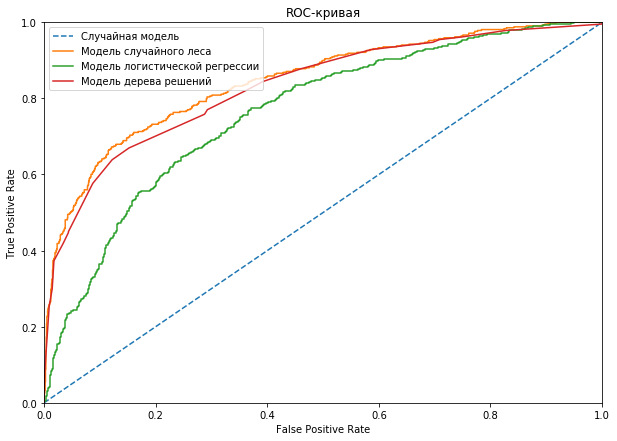

In [27]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_RandomForestClassifier_UpsampleClass,tpr_RandomForestClassifier_UpsampleClass)
plt.plot(fpr_LogisticRegression_UpsampleClass,tpr_LogisticRegression_UpsampleClass)
plt.plot(fpr_DecisionTreeClassifier_UpsampleClass,tpr_DecisionTreeClassifier_UpsampleClass)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Модель случайного леса','Модель логистической регрессии','Модель дерева решений'),
           loc= 'upper left') 
plt.show()

В результате проведенных экспериментов удалось добиться значение F1 > 0,59 на моделях дерева решений при нормализации выборок путем увеличения и уменьшения отрицательных признаков, а также на модели случайного дерева при любой выборке.

Для закрепления результата необходимо обкатать данные модели на тестовой выборке и проверить их на адекватность.

<a id="step_5"></a>
<b>Тестирование модели</b>

Проверим нашу наилучшую модель (модель случайного дерева) на тестовой выборке.

Для этого совместим тренировочную и валидационную выборки вместе, обучим на совмещенной и проверим на тестовой

In [28]:
features = pd.concat ([features_train] + [features_valid])
target = pd.concat ([target_train] + [target_valid])

In [32]:
prediction = model_RandomForestClassifier_UpsampleClass.predict (features_test)

print ('F1', f1_score (target_test, prediction))
probabilities_test = model_RandomForestClassifier_UpsampleClass.predict_proba (features_test)[:, 1]
fpr, tpr, thresholds = roc_curve (target_test, probabilities_test)
print ("AUC-ROC", roc_auc_score (target_test, probabilities_test))

F1 0.6139088729016786
AUC-ROC 0.8541174777497447


Модель случайного леса с подобранными заранее гиперпараметрами на увеличенной выборке положительного клаcса показала себя успешнее всего и дала нам результат F1 0.6139088729016786 при AUC-ROC 0.8541174777497447

Данное уже лишнее:

#При переобучении данной модели на объединенной выборке с перебором гиперпараметров, данная модель показала себя также адекватно #и дала нам результат F1 0.6077348066298343 при AUC-ROC 0.8563706112242925

<Figure size 432x288 with 0 Axes>

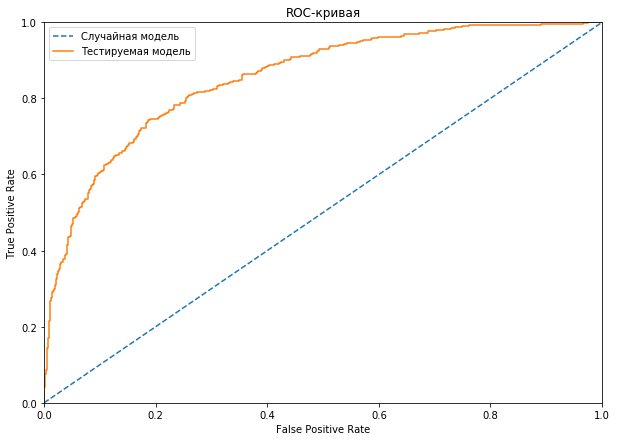

In [33]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Тестируемая модель'),
           loc= 'upper left') 
plt.show()

По графику ROC-кривой мы также видим, что наша модель успешно справляется в сравнении со случайной моделью.

Проверим нашу модель на адекватность.

Для этого сравним ее показатели с базовой моделью.

In [36]:
#посмотрим результаты на базовой моделе
model_DummyClassifier = DummyClassifier (random_state = 12345)
model_DummyClassifier.fit (features, target)
prediction = model_DummyClassifier.predict (features_test)

print ('F1', f1_score (target_test, prediction))
probabilities_test = model_DummyClassifier.predict_proba (features_test)[:, 0]
print ("AUC-ROC", roc_auc_score (target_test, probabilities_test))

F1 0.19664268585131892
AUC-ROC 0.5073852708332396


При проверке на адекватность наша модель показала себя более чем адекватно. Показатели F1 и AUC-ROC более чем наглядно это показывают.

<a id="step_6"></a>
<b>Общий вывод</b>

По результатам проделанной работы можем рекомендовать для прогнозирования оттока клиентов модель случайного леса, обученной на увеличенной положительной выборке.

На проверочных (тестовых) данных она показала себя более чем адекватно при:
F1 0.6139088729016786
AUC-ROC 0.8541174777497447

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*